In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier

2024-01-29 00:58:08.372458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 00:58:08.372519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 00:58:08.373307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 00:58:08.379211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 00:58:09.268977: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}

In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']

label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=some_dataframes, input_features=input_features_reduced_further,
                                      with_labels=True,
                                      train_val_split=0.8, input_stride=2, padding='none',
                                      pad_location_labels=0,
                                      input_history_steps=1, input_future_steps=50, seed=69)


=========================Creating Generator=======================
Seed: 69
nTrain: 800 nVal: 200 (0.80)
Padding: none
Scaling: True 
Horizons: 1-50 @ stride 2
Sin-Transformed features: []
=========================Finished Generator=======================


In [4]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=512, 
                                                   label_features=['EW_Type', 'NS_Type'], 
                                                   with_identifier=False, 
                                                   only_nodes=False, 
                                                   shuffle=True, 
                                                   stride=3)

print(train_combined.element_spec)


2024-01-29 00:58:59.445616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 00:58:59.469748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 00:58:59.469821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 00:58:59.472340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 00:58:59.472424: I external/local_xla/xla/stream_executor

(TensorSpec(shape=(None, 26, 6), dtype=tf.float64, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 26, 6)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 156)                  0         ['Input[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 156)                  0         ['flatten[0][0]']             
                                                                                                  
 dense (Dense)               (None, 64)                   10048     ['dropout[0][0]']             
                                                                                              

2024-01-29 00:59:10.514968: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efc90016930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-29 00:59:10.515025: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-01-29 00:59:10.522760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-29 00:59:11.104625: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706486351.204092   72576 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1107/1107 - 17s - loss: 1.7409 - EW_Type_loss: 0.8904 - NS_Type_loss: 0.8332 - EW_Type_accuracy: 0.6304 - NS_Type_accuracy: 0.6545 - val_loss: 2.0552 - val_EW_Type_loss: 0.9179 - val_NS_Type_loss: 1.1194 - val_EW_Type_accuracy: 0.6033 - val_NS_Type_accuracy: 0.5556 - 17s/epoch - 16ms/step
Epoch 2/15
1107/1107 - 13s - loss: 1.4902 - EW_Type_loss: 0.7441 - NS_Type_loss: 0.7276 - EW_Type_accuracy: 0.7051 - NS_Type_accuracy: 0.7188 - val_loss: 1.8981 - val_EW_Type_loss: 0.9160 - val_NS_Type_loss: 0.9629 - val_EW_Type_accuracy: 0.5972 - val_NS_Type_accuracy: 0.5658 - 13s/epoch - 12ms/step
Epoch 3/15
1107/1107 - 12s - loss: 1.4001 - EW_Type_loss: 0.6988 - NS_Type_loss: 0.6815 - EW_Type_accuracy: 0.7141 - NS_Type_accuracy: 0.7249 - val_loss: 1.9837 - val_EW_Type_loss: 0.9390 - val_NS_Type_loss: 1.0242 - val_EW_Type_accuracy: 0.5986 - val_NS_Type_accuracy: 0.5953 - 12s/epoch - 11ms/step
Epoch 4/15
1107/1107 - 13s - loss: 1.3572 - EW_Type_loss: 0.6867 - NS_Type_loss: 0.6496 - EW_Type_accuracy: 

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


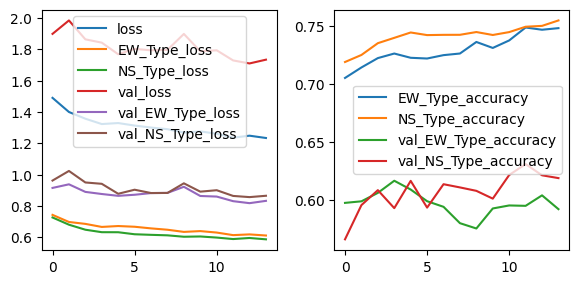

In [5]:
# train_combined, val_combined = ds_gen.get_datasets(batch_size=512, label_features=['EW_Type', 'NS_Type'], with_identifier=False, shuffle=True, stride=4)
# print(train_combined.element_spec)

#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.5, lr_scheduler=[10000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], 
                                       dense_layers=[64,32,16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.3, 
                                       lr_scheduler=[30000,0.9], seed=0)

dense_model.summary()

# temporary fix to allow class weights
# train_combined = train_combined.map(lambda x,y:(x,y[f'EW_Node']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Node'])) 

w_0 = 21.3
w_1 = 22.0
w_2 = 16.0
w_3 = 2.9

hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=15, verbose=2, plot_hist=True,
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

In [6]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_new.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_new.hdf5')

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
pickle.dump(ds_gen.scaler, open('models/ew_ns_classifier_scaler_new.pkl', 'wb'))

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=10, verbose=2, plot_hist=True, callbacks=[])

In [6]:
#dense_model.model.save('models/ew_ns_classifier.hdf5')

In [9]:
dense_model = tf.keras.models.load_model('/home/david/Code/splid-challenge/models/ew_ns_type_classifier_new.hdf5')


In [7]:
from base import classifier

pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],
                                verbose=1)
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv').sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

majority_df = classifier.apply_majority_method(preds_df=pred_df, location_df=ground_truth_df)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

2024-01-29 01:02:37.819431: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2119488384 exceeds 10% of free system memory.
2024-01-29 01:02:38.848770: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2119488384 exceeds 10% of free system memory.


13272/13272 [==============================] - 36s 3ms/step
Precision: 0.62
TP: 599 FP: 369


In [ ]:
ground_truth_df = ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
majority_df = classifier.apply_majority_method(preds_df=pred_df, location_df=ground_truth_df)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

In [ ]:
eval_df, gt_df, evaluator = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                 dense_model,
                                                 model_outputs=['EW_Type', 'NS_Type'],
                                                 train=False,
                                                 majority_segment_labels=True,
                                                 with_initial_node=True,
                                                 only_initial_nodes=True)
                                                 
# Dense: worse
# LSTM 40-40@2 same-padding: 0.51
# LSTM 40-40@2 zero-padding: 0.49
# LSTM 80-80@5: 0.49

# TODO: determine class imbalance for the classifier - maybe nodes should be trained without considering SS at all, as it will never be a necessary classification?
# Maybe also really only train on changepoints...
# TODO: for type, maybe take majority value between timesteps?
# -> New approach seems to be much better for initial nodes!

  0%|          | 0/5 [00:00<?, ?it/s]

/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 20%|██        | 1/5 [00:20<01:22, 20.51s/it]

0.9057142857142857 0.8733333333333333


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 40%|████      | 2/5 [00:42<01:03, 21.21s/it]

0.8942857142857144 0.88


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 60%|██████    | 3/5 [01:04<00:43, 21.67s/it]

0.9066666666666667 0.8688888888888888


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 80%|████████  | 4/5 [01:24<00:20, 20.93s/it]

0.9135714285714286 0.8533333333333333


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
100%|██████████| 5/5 [01:43<00:00, 20.79s/it]

0.9154285714285715 0.8480000000000001
Train:
avg-Precision: 0.92
avg-TP: 320.4 avg-FP: 29.6
Val:
avg-Precision: 0.85
avg-TP: 127.2 avg-FP: 22.8


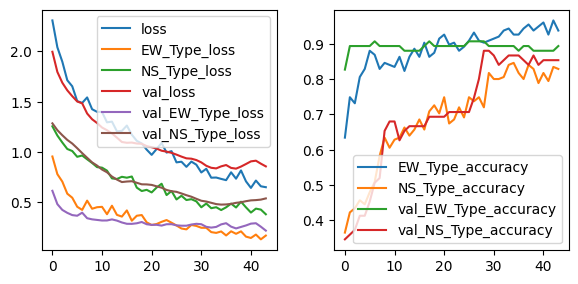

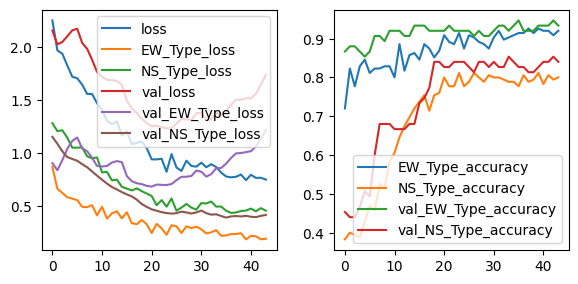

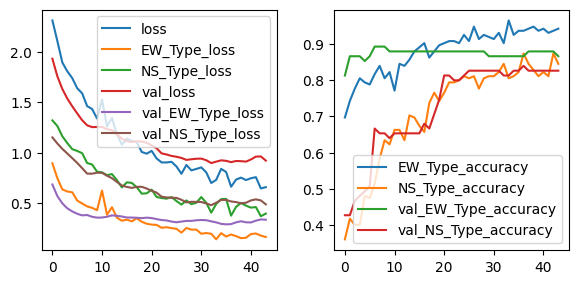

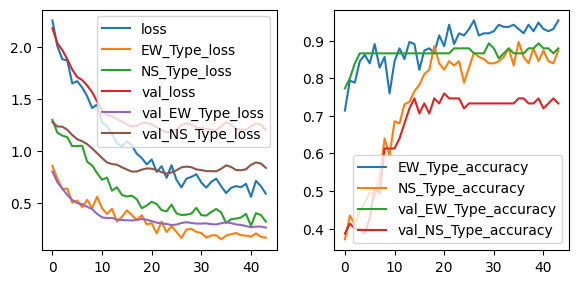

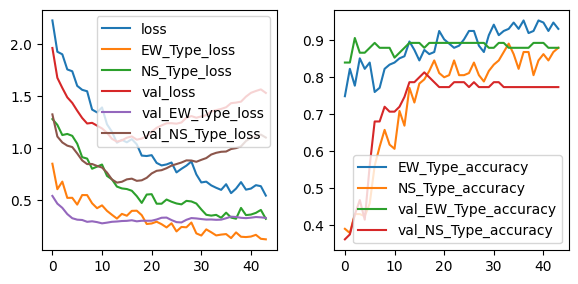

In [21]:
def train_and_eval(seed):
    ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      with_labels=True,
                                      train_val_split=0.7, input_stride=2, padding='none',
                                      pad_location_labels=1,
                                      input_history_steps=1, input_future_steps=400, seed=seed, verbose=0)
    t_ds, v_ds = ds_gen.get_datasets(batch_size=64, label_features=['EW_Type', 'NS_Type'], with_identifier=False, only_nodes=True, shuffle=True, stride=1)

    # temporary fix to allow class weights
    # t_ds = t_ds.map(lambda x,y:(x,y[f'EW_Node']))
    # v_ds = v_ds.map(lambda x,y:(x,y[f'EW_Node'])) 

    w_0_CK = 21.3
    w_1_EK = 22.0
    w_2_HK = 16.0
    w_3_NK = 2.9

    model = prediction_models.Dense_NN(v_ds, conv1d_layers=[], 
                                       dense_layers=[32,16], l2_reg=0.001, input_dropout=0.1, mixed_dropout=0.5,
                                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                                       lr_scheduler=[10000,0.9], seed=0)
    #model = prediction_models.LSTM_NN(t_ds, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
    model.fit(t_ds, val_ds=v_ds, epochs=45, verbose=0, plot_hist=True, callbacks=[])
    scores_t = {}
    scores_v = {}
    for train in [False, True]:
        scores = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                    model,
                                                    model_outputs=['EW_Type', 'NS_Type'],
                                                    train=train,
                                                    majority_segment_labels=False,
                                                    with_initial_node=True,
                                                    only_initial_nodes=True,
                                                    return_scores=True,
                                                    verbose=0)
        if train:
            scores_t = scores
        else:
            scores_v = scores
    return scores_t, scores_v
def k_fold_train_and_eval(n_folds=3):
    
    avg_p_t, avg_tp_t, avg_fp_t = 0.0, 0.0, 0.0
    avg_p_v, avg_tp_v, avg_fp_v = 0.0, 0.0, 0.0
    for fold in tqdm(range(n_folds)):
        scores_t, scores_v = train_and_eval(fold)
        avg_p_t += scores_t['Precision']
        avg_tp_t += scores_t['TP']
        avg_fp_t += scores_t['FP']
        avg_p_v += scores_v['Precision']
        avg_tp_v += scores_v['TP']
        avg_fp_v += scores_v['FP']
        print(avg_p_t/(fold+1.0), avg_p_v/(fold+1.0))
    avg_p_t=avg_p_t/float(n_folds)
    avg_tp_t=avg_tp_t/float(n_folds)
    avg_fp_t=avg_fp_t/float(n_folds)
    avg_p_v=avg_p_v/float(n_folds)
    avg_tp_v=avg_tp_v/float(n_folds)
    avg_fp_v=avg_fp_v/float(n_folds)

    print('Train:')
    print(f'avg-Precision: {avg_p_t:.2f}')
    print(f'avg-TP: {avg_tp_t:.1f} avg-FP: {avg_fp_t:.1f}')
    print('Val:')
    print(f'avg-Precision: {avg_p_v:.2f}')
    print(f'avg-TP: {avg_tp_v:.1f} avg-FP: {avg_fp_v:.1f}')

k_fold_train_and_eval(5)

# 89 86
# 94 89 (500 hoizon, input-stride 1)
# 91 87 (500 hoizon, input-stride 4)
# 90 87 (500 hoizon, input-stride 2)
# 89 87 (500 hoizon, input-stride 4, small af model)
# 91 88 (400 hoizon, input-stride 2, small af model)
# 90 87 (300 hoizon, input-stride 2, small af model)

# TODO: add class weights, esp. EK!

/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


8/8 [==============================] - 0s 3ms/step
Assuming perfect nodes
Considering ONLY initial nodes
Precision: 0.91
TP: 429 FP: 45


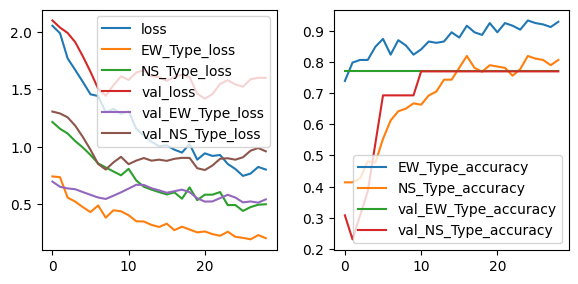

In [24]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      with_labels=True,
                                      train_val_split=0.95, input_stride=2, padding='none',
                                      pad_location_labels=1,
                                      input_history_steps=1, input_future_steps=400, seed=69, verbose=0)
t_ds, v_ds = ds_gen.get_datasets(batch_size=64, label_features=['EW_Type', 'NS_Type'], with_identifier=False, only_nodes=True, shuffle=True, stride=1)

model = prediction_models.Dense_NN(v_ds, conv1d_layers=[], 
                                    dense_layers=[32,16], l2_reg=0.001, input_dropout=0.1, mixed_dropout=0.5,
                                    #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                                    lr_scheduler=[10000,0.9], seed=0)
#model = prediction_models.LSTM_NN(t_ds, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
model.fit(t_ds, val_ds=v_ds, epochs=30, verbose=0, plot_hist=True, callbacks=[])

scores = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                    model,
                                                    model_outputs=['EW_Type', 'NS_Type'],
                                                    train=True,
                                                    majority_segment_labels=False,
                                                    with_initial_node=True,
                                                    only_initial_nodes=True,
                                                    return_scores=True,
                                                    verbose=1)

In [27]:
model.model.save('models/ss_type_classifier.hdf5')
pickle.dump(ds_gen.scaler, open('models/ss_type_classifier_scaler.pkl', 'wb'))

In [7]:
eval_df, gt_df, evaluator = evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                 dense_model.model,
                                                 model_outputs=['EW_Type', 'NS_Type'],
                                                 train=True,
                                                 with_initial_node=True)

15707/15707 - 39s - 39s/epoch - 2ms/step
Assuming perfect nodes
Precision: 0.95
TP: 449 FP: 25


In [13]:
eval_df = eval_df.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
eval_df

,ObjectID,TimeIndex,EW_Node_Pred,EW_Node,Direction,Type,Node
0,104,99,0.0,AD,EW,NK,AD
1,104,126,0.0,AD,EW,NK,AD
2,107,68,2.0,IK,EW,CK,IK
3,107,74,0.0,AD,EW,NK,AD
4,114,200,2.0,IK,EW,CK,IK
...,...,...,...,...,...,...,...
57,215,912,0.0,AD,EW,NK,AD
58,215,930,2.0,IK,EW,HK,IK
59,221,275,0.0,AD,EW,NK,AD
60,221,298,0.0,AD,EW,NK,AD


In [10]:
print(gt_df.head(20))
print(len(gt_df))

     ObjectID  TimeIndex Direction Node Type
28         10          0        EW   SS   CK
29         10          0        NS   SS   NK
30         10        216        NS   IK   CK
31         10       2171        ES   ES   ES
45         15          0        EW   SS   EK
46         15          0        NS   SS   CK
47         15       2171        ES   ES   ES
64         21          0        EW   SS   HK
65         21          0        NS   SS   HK
66         21       2171        ES   ES   ES
79         26          0        EW   SS   CK
80         26          0        NS   SS   CK
81         26       2207        ES   ES   ES
91         30          0        EW   SS   CK
92         30          0        NS   SS   NK
93         30       2207        ES   ES   ES
109        36          0        EW   SS   CK
110        36          0        NS   SS   NK
111        36       2171        ES   ES   ES
136        45          0        EW   SS   CK
220


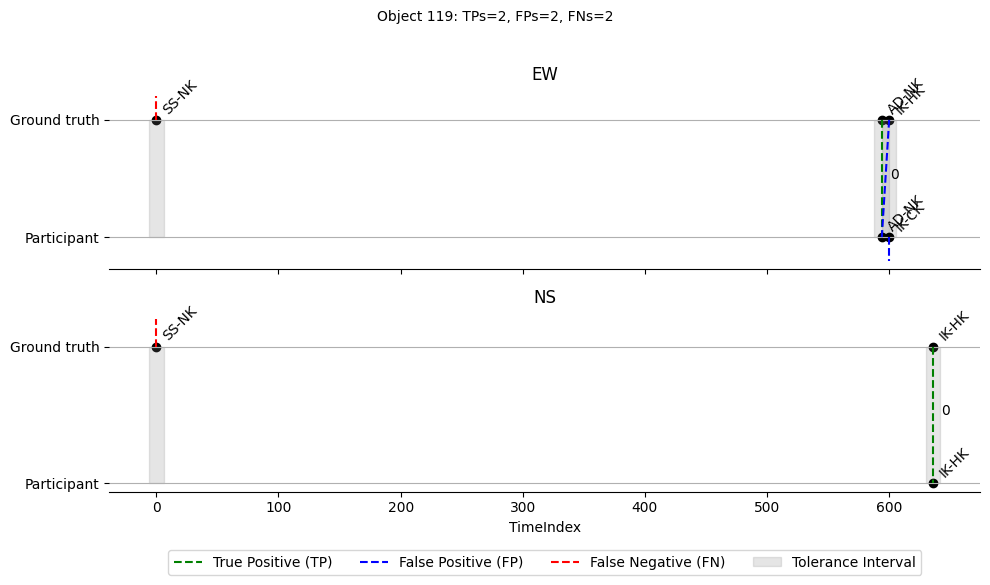

In [9]:
evaluator.plot(119)

In [28]:
t_ds, v_ds = ds_gen.get_datasets(batch_size=None, label_features=['EW_Node'], with_identifier=True, shuffle=False, stride=1)
labels = np.concatenate([element for element in t_ds.map(lambda x,y,z: [y['EW_Node']]).as_numpy_iterator()])
print(labels.shape)
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

(412124,)
{0: 38625, 1: 37452, 2: 51356, 3: 284691}


In [29]:
total = np.sum(counts)
w_0 = (1.0/counts[0])*(total*2.0)
w_1 = (1.0/counts[1])*(total*2.0)
w_2 = (1.0/counts[2])*(total*2.0)
w_3 = (1.0/counts[3])*(total*2.0)
print(f'w_0 = {w_0}')
print(f'w_1 = {w_1}')
print(f'w_2 = {w_2}')
print(f'w_3 = {w_3}')

w_0 = 21.339754045307444
w_1 = 22.008117056498985
w_2 = 16.04969234364047
w_3 = 2.8952372923625966


In [14]:
print(ds_gen.node_label_encoder.transform(['SS', 'ID', 'AD', 'IK']))
print(ds_gen.type_label_encoder.transform(['NK', 'CK', 'EK', 'HK']))

[3 1 0 2]
[3 0 1 2]


In [10]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True)
# LSTM 40-40@2: 0.49
# LSTM 40-40@2 zero-padding: 0.52
# LSTM 80-80@5: 0.51

14/14 [==============================] - 0s 11ms/step
Precision: 0.52
TP: 367 FP: 336


In [10]:
print(eval_df['Type'].unique())

['CK' 'NK']


In [23]:

labels=pd.read_csv(labels_dir)
labels = labels.loc[(labels['ObjectID'].isin(map(int, ds_gen.val_keys)))]
labels = labels.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(len(labels) - (len(ds_gen.val_keys)*3))
print(labels.head(5))

70
   ObjectID  TimeIndex Direction Node Type
0        10          0        EW   SS   CK
1        10          0        NS   SS   NK
2        10        216        NS   IK   CK
3        10       2171        ES   ES   ES
4        15          0        EW   SS   EK
